# Notebook 05 - Mod√©lisation des √©motions (GoEmotions)

# 1 - Imports & configuration

In [1]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import mlflow
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

from src.utils.tree_utils import afficher_arborescence
from src.pipeline_emotions import run_emotion_pipeline
from src.utils.visualization_utils import plot_normalized_metrics

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0519 11:58:24.746000 21052 venv_P9_V2\Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


# 2 - Arborescence du projet

In [2]:
print("üìÇ Arborescence du projet :")
afficher_arborescence('..', niveau_max = 1)

üìÇ Arborescence du projet :
‚îú‚îÄ‚îÄ %USERPROFILE%.git-credentials
‚îú‚îÄ‚îÄ .coverage
‚îú‚îÄ‚îÄ .git
‚îÇ   ‚îú‚îÄ‚îÄ COMMIT_EDITMSG
‚îÇ   ‚îú‚îÄ‚îÄ HEAD
‚îÇ   ‚îú‚îÄ‚îÄ config
‚îÇ   ‚îú‚îÄ‚îÄ description
‚îÇ   ‚îú‚îÄ‚îÄ hooks
‚îÇ   ‚îú‚îÄ‚îÄ index
‚îÇ   ‚îú‚îÄ‚îÄ info
‚îÇ   ‚îú‚îÄ‚îÄ logs
‚îÇ   ‚îú‚îÄ‚îÄ objects
‚îÇ   ‚îú‚îÄ‚îÄ refs
‚îú‚îÄ‚îÄ .github
‚îÇ   ‚îú‚îÄ‚îÄ workflows
‚îú‚îÄ‚îÄ .gitignore
‚îú‚îÄ‚îÄ .history
‚îÇ   ‚îú‚îÄ‚îÄ .github
‚îÇ   ‚îú‚îÄ‚îÄ .gitignore_20250515103945
‚îÇ   ‚îú‚îÄ‚îÄ .gitignore_20250515142538
‚îÇ   ‚îú‚îÄ‚îÄ .gitignore_20250515153648
‚îÇ   ‚îú‚îÄ‚îÄ app_20250515074448.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250515135249.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250515135349.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250515143110.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250518103623.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250518103849.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250518105122.py
‚îÇ   ‚îú‚îÄ‚îÄ requirements_20250515104459.txt
‚îÇ   ‚îú‚îÄ‚îÄ requirements_20250515143348.txt
‚îÇ   ‚îú‚îÄ‚îÄ results
‚îÇ   ‚îú‚îÄ‚îÄ src
‚îÇ   ‚îú‚îÄ‚îÄ tests

# 3 - Chargement du dataset GoEmotions

In [3]:
data_path = os.path.join("..", "data", "raw", "goemotions.csv")
df = pd.read_csv(data_path)

print("‚úÖ Dimensions du dataset :", df.shape)
# df.head()

‚úÖ Dimensions du dataset : (211225, 37)


## 3.1 - Cr√©ation de la colonne "labels" multi-index√©e (0 √† 27)

In [4]:
emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]  # colonnes d‚Äô√©motions (28 colonnes apr√®s les m√©tadonn√©es)
df['labels'] = df[emotion_cols].apply(lambda row: [i for i, v in enumerate(row) if v == 1], axis=1)

In [5]:
print("‚úÖ Dimensions du dataset :", df.shape)
print("üìä Nombre moyen d‚Äô√©motions par tweet :", df['labels'].apply(len).mean())
df[['text', 'labels']].head()

‚úÖ Dimensions du dataset : (211225, 38)
üìä Nombre moyen d‚Äô√©motions par tweet : 1.1813421706710854


text labels
0                                    That game hurt.   [25]
1   >sexuality shouldn‚Äôt be a grouping category I...     []
2     You do right, if you don't care then fuck 'em!   [27]
3                                 Man I love reddit.   [18]
4  [NAME] was nowhere near them, he was by the Fa...   [27]

# 4 - Statistiques de base

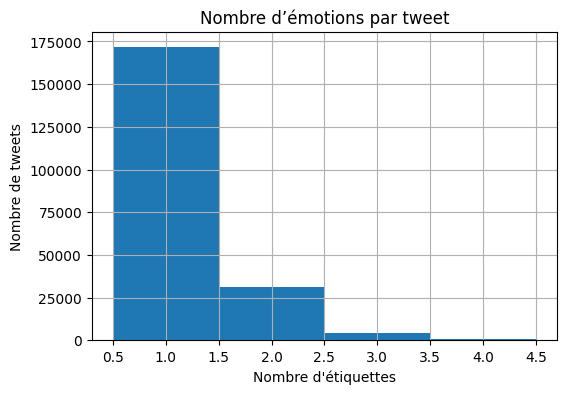

In [6]:
df['n_emotions'] = df['labels'].apply(len)
df['n_emotions'].hist(bins=range(1, 6), align='left', figsize=(6, 4))
plt.title("Nombre d‚Äô√©motions par tweet")
plt.xlabel("Nombre d'√©tiquettes")
plt.ylabel("Nombre de tweets")
plt.grid(True)
plt.show()

## 4.1 - R√©partition des √©motions globales

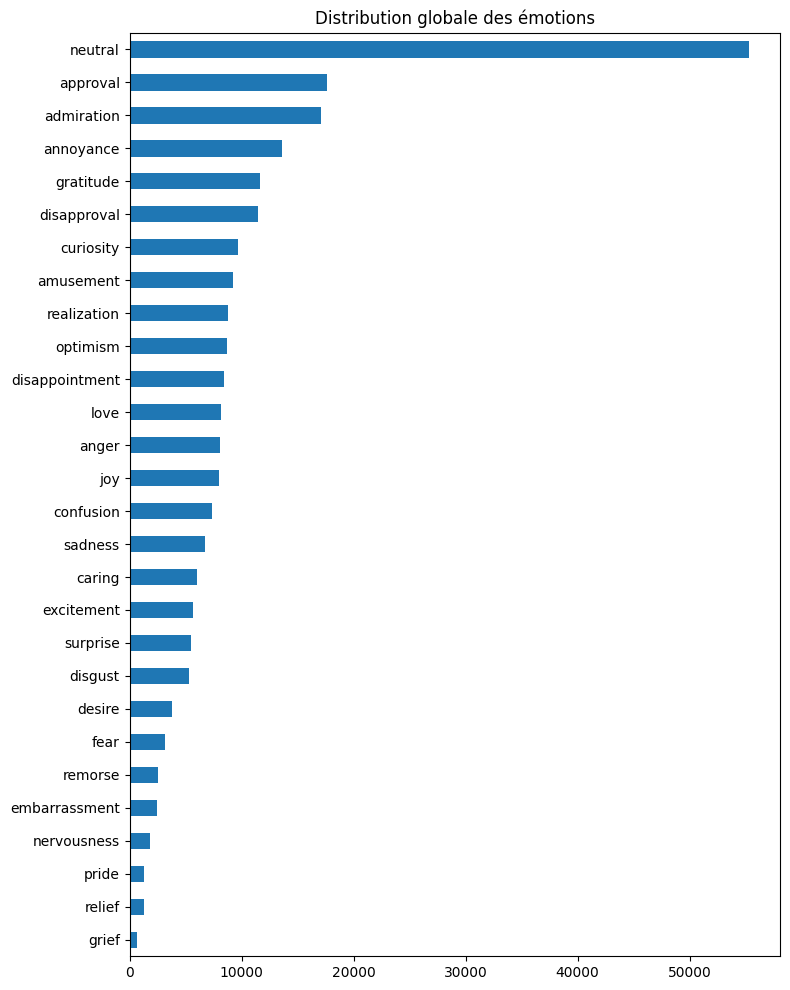

In [7]:
df[emotion_cols].sum().sort_values().plot(kind="barh", figsize=(8, 10))
plt.title("Distribution globale des √©motions")
plt.tight_layout()
plt.show()

# 5 - Nuage de mots

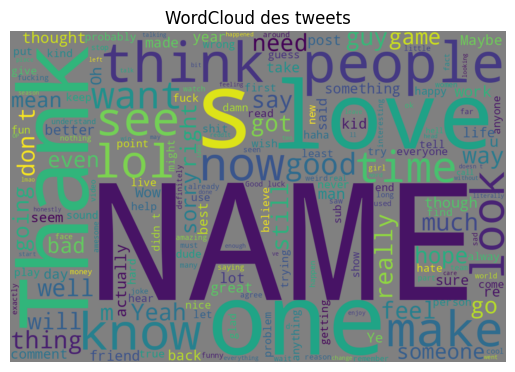

In [8]:
all_text = " ".join(df['text'].tolist())
wordcloud = WordCloud(width = 1200, height = 800, background_color = "grey").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des tweets")
plt.show()

# 6 - Entra√Ænement du mod√®le via pipeline sur GoEmotions (multi-label √† 28 classes)

Un mod√®le ELECTRA est entra√Æn√© pour la t√¢che d‚Äôanalyse fine des √©motions √† partir du dataset **GoEmotions**, contenant **28 √©tiquettes √©motionnelles** (col√®re, joie, peur, admiration, etc.).

Contrairement √† une t√¢che de classification binaire, chaque tweet peut exprimer **plusieurs √©motions simultan√©ment**. Il s‚Äôagit donc d‚Äôun probl√®me de **classification multi-label**, n√©cessitant une adaptation sp√©cifique du mod√®le, de la fonction de perte et des m√©triques d‚Äô√©valuation.

---

### ‚öôÔ∏è Param√©trage du pipeline `run_emotion_pipeline()`

- ‚úÖ **Mod√®le utilis√©** : `electra-small-discriminator`, charg√© en **local** (dossier `models/hf_assets/`)
- ‚úÖ **Tokenization** : via `AutoTokenizer`, avec padding automatique et troncature (`max_length`)
- ‚úÖ **Head de classification** :
  - `num_labels = 28` (une sortie par √©motion)
  - `problem_type = "multi_label_classification"` (sortie `sigmoid` par √©tiquette)

---

### üß† Donn√©es utilis√©es

- ‚úÖ **Source** : fichier `goemotions.csv` (28 colonnes binaires d‚Äô√©motions)
- ‚úÖ **R√©duction** :
  - √©chantillon al√©atoire √† **50 000 lignes** (hors `test_mode`)
- ‚úÖ **Sur√©chantillonnage l√©ger** :
  - les classes pr√©sentes moins de `150 fois` sont **dupliqu√©es avec remplacement**
  - permet une meilleure repr√©sentativit√© des √©motions rares sans √©crasement des autres classes
- ‚úÖ **Encodage des labels** :
  - fusion des colonnes binaires en vecteurs `labels` multi-labels `float32`

---

### ‚öñÔ∏è Gestion des d√©s√©quilibres

- ‚úÖ Calcul de **poids de classe** (`class_weights`) :
  - pond√©ration logarithmique : `log1p(1 / fr√©quence)`
  - plus les classes sont rares, plus elles sont pond√©r√©es
- ‚úÖ Int√©gration dans la loss :
  - `BCEWithLogitsLoss(pos_weight=class_weights)`
- ‚úÖ Enregistrement des poids dans MLflow (`class_weight_nom_emotion`)

---

### üß™ Param√®tres d‚Äôentra√Ænement

- ‚úÖ Entra√Ænement via `Trainer` avec GPU (v√©rification CUDA)
- ‚úÖ Hyperparam√®tres :
  - `batch_size = 16` (train) / `32` (eval)
  - `num_train_epochs = 5`
  - `learning_rate = 3e-5`, `weight_decay = 0.01`
  - `warmup_ratio = 0.1`, `lr_scheduler_type = "cosine"`
  - `fp16 = True` (acc√©l√©ration GPU en mode mixed precision)
- ‚úÖ Callbacks :
  - `EarlyStoppingCallback(patience=2)`
  - `PrinterCallback` supprim√© pour limiter les logs excessifs

---

### üìà √âvaluation et m√©triques

- ‚úÖ **Seuil de pr√©diction** : `sigmoid > 0.25` (valeur fix√©e dans `THRESHOLD`)
- ‚úÖ **M√©triques utilis√©es** :
  - `f1_score` (micro-avg)
  - `accuracy_score`
- ‚úÖ **√âchantillon d‚Äô√©valuation** : les **100 premiers exemples** du dataset

---

### üì¶ MLOps et enregistrement via MLflow

- ‚úÖ **Artefacts logg√©s** :
  - mod√®le (`model.save_pretrained(...)`)
  - tokenizer (`tokenizer.save_pretrained(...)`)
  - m√©triques `f1` et `accuracy` dans `metrics.pkl`
- ‚úÖ **Tracking MLflow** :
  - tous les hyperparam√®tres (`training_args.to_dict()`)
  - m√©triques globales
  - `class_weights` par classe

---

> üîÅ Le pipeline est relan√ßable √† volont√© :
> - `force_retrain = True` pour forcer un nouvel entra√Ænement complet
> - Sinon, reprise automatique depuis le dernier checkpoint d√©tect√©
>
> üìÇ Tous les r√©sultats sont enregistr√©s dans `models/emotions/`, ind√©pendamment du mod√®le binaire de classification sentimentale.


In [9]:
model, tokenizer, metrics = run_emotion_pipeline(force_retrain = True, test_mode=False)

Some weights of the model checkpoint at c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\models\hf_assets\electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkp

{'loss': 0.749, 'learning_rate': 1.923076923076923e-06, 'epoch': 0.03}


  1%|‚ñè         | 200/15595 [01:31<1:56:10,  2.21it/s]

{'loss': 0.7374, 'learning_rate': 3.846153846153846e-06, 'epoch': 0.06}


  2%|‚ñè         | 300/15595 [02:16<1:55:13,  2.21it/s]

{'loss': 0.7104, 'learning_rate': 5.76923076923077e-06, 'epoch': 0.1}


  3%|‚ñé         | 400/15595 [03:02<1:55:07,  2.20it/s]

{'loss': 0.6626, 'learning_rate': 7.692307692307692e-06, 'epoch': 0.13}


  3%|‚ñé         | 500/15595 [03:47<1:54:06,  2.20it/s]

{'loss': 0.5929, 'learning_rate': 9.615384615384616e-06, 'epoch': 0.16}


  4%|‚ñç         | 600/15595 [04:32<1:52:41,  2.22it/s]

{'loss': 0.5062, 'learning_rate': 1.153846153846154e-05, 'epoch': 0.19}


  4%|‚ñç         | 700/15595 [05:18<1:53:08,  2.19it/s]

{'loss': 0.4377, 'learning_rate': 1.3461538461538462e-05, 'epoch': 0.22}


  5%|‚ñå         | 800/15595 [06:03<1:51:20,  2.21it/s]

{'loss': 0.3992, 'learning_rate': 1.5384615384615384e-05, 'epoch': 0.26}


  6%|‚ñå         | 900/15595 [06:48<1:51:23,  2.20it/s]

{'loss': 0.3815, 'learning_rate': 1.7307692307692306e-05, 'epoch': 0.29}


  6%|‚ñã         | 1000/15595 [07:34<1:50:14,  2.21it/s]

{'loss': 0.3752, 'learning_rate': 1.923076923076923e-05, 'epoch': 0.32}


  7%|‚ñã         | 1100/15595 [08:19<1:49:43,  2.20it/s]

{'loss': 0.3769, 'learning_rate': 2.1153846153846157e-05, 'epoch': 0.35}


  8%|‚ñä         | 1200/15595 [09:04<1:48:23,  2.21it/s]

{'loss': 0.361, 'learning_rate': 2.307692307692308e-05, 'epoch': 0.38}


  8%|‚ñä         | 1300/15595 [09:50<1:47:37,  2.21it/s]

{'loss': 0.3755, 'learning_rate': 2.5e-05, 'epoch': 0.42}


  9%|‚ñâ         | 1400/15595 [10:35<1:48:35,  2.18it/s]

{'loss': 0.3702, 'learning_rate': 2.6923076923076923e-05, 'epoch': 0.45}


 10%|‚ñâ         | 1500/15595 [11:21<1:46:24,  2.21it/s]

{'loss': 0.3755, 'learning_rate': 2.884615384615385e-05, 'epoch': 0.48}


 10%|‚ñà         | 1600/15595 [12:06<1:45:46,  2.21it/s]

{'loss': 0.3683, 'learning_rate': 2.9999398752537962e-05, 'epoch': 0.51}


 11%|‚ñà         | 1700/15595 [12:51<1:45:04,  2.20it/s]

{'loss': 0.3614, 'learning_rate': 2.9992635272122454e-05, 'epoch': 0.55}


 12%|‚ñà‚ñè        | 1800/15595 [13:37<1:43:55,  2.21it/s]

{'loss': 0.353, 'learning_rate': 2.9978360151913107e-05, 'epoch': 0.58}


 12%|‚ñà‚ñè        | 1900/15595 [14:22<1:43:14,  2.21it/s]

{'loss': 0.3572, 'learning_rate': 2.9956580544058907e-05, 'epoch': 0.61}


 13%|‚ñà‚ñé        | 2000/15595 [15:07<1:42:51,  2.20it/s]

{'loss': 0.3643, 'learning_rate': 2.992730736062208e-05, 'epoch': 0.64}


 13%|‚ñà‚ñé        | 2100/15595 [15:53<1:42:28,  2.19it/s]

{'loss': 0.349, 'learning_rate': 2.989055526811092e-05, 'epoch': 0.67}


 14%|‚ñà‚ñç        | 2200/15595 [16:38<1:40:54,  2.21it/s]

{'loss': 0.3433, 'learning_rate': 2.9846342680131553e-05, 'epoch': 0.71}


 15%|‚ñà‚ñç        | 2300/15595 [17:23<1:39:37,  2.22it/s]

{'loss': 0.3489, 'learning_rate': 2.9794691748162295e-05, 'epoch': 0.74}


 15%|‚ñà‚ñå        | 2400/15595 [18:09<1:39:53,  2.20it/s]

{'loss': 0.3564, 'learning_rate': 2.97356283504553e-05, 'epoch': 0.77}


 16%|‚ñà‚ñå        | 2500/15595 [18:54<1:38:48,  2.21it/s]

{'loss': 0.3419, 'learning_rate': 2.9669182079070974e-05, 'epoch': 0.8}


 17%|‚ñà‚ñã        | 2600/15595 [19:40<1:38:01,  2.21it/s]

{'loss': 0.3307, 'learning_rate': 2.95953862250517e-05, 'epoch': 0.83}


 17%|‚ñà‚ñã        | 2700/15595 [20:25<1:36:44,  2.22it/s]

{'loss': 0.3303, 'learning_rate': 2.951427776174229e-05, 'epoch': 0.87}


 18%|‚ñà‚ñä        | 2800/15595 [21:10<1:36:08,  2.22it/s]

{'loss': 0.3316, 'learning_rate': 2.9425897326265552e-05, 'epoch': 0.9}


 19%|‚ñà‚ñä        | 2900/15595 [21:56<1:35:53,  2.21it/s]

{'loss': 0.3276, 'learning_rate': 2.9330289199162165e-05, 'epoch': 0.93}


 19%|‚ñà‚ñâ        | 3000/15595 [22:41<1:34:56,  2.21it/s]

{'loss': 0.3249, 'learning_rate': 2.922750128220517e-05, 'epoch': 0.96}


 20%|‚ñà‚ñâ        | 3100/15595 [23:26<1:35:03,  2.19it/s]

{'loss': 0.3244, 'learning_rate': 2.9117585074400145e-05, 'epoch': 0.99}


 20%|‚ñà‚ñà        | 3119/15595 [23:35<1:28:54,  2.34it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values d

{'eval_loss': 0.32606810331344604, 'eval_f1_micro': 0.2844, 'eval_f1_macro': 0.1322, 'eval_f1_weighted': 0.2748, 'eval_accuracy': 0.14, 'eval_hamming_loss': 0.1114, 'eval_log_loss': 3.2379, 'eval_roc_auc_micro': 0.815, 'eval_pr_auc_macro': 0.2036, 'eval_coverage_error': 6.15, 'eval_lrap': 0.534, 'eval_runtime': 0.9259, 'eval_samples_per_second': 108.006, 'eval_steps_per_second': 4.32, 'epoch': 1.0}


 21%|‚ñà‚ñà        | 3200/15595 [24:13<1:33:58,  2.20it/s]

{'loss': 0.3238, 'learning_rate': 2.9000595646183036e-05, 'epoch': 1.03}


 21%|‚ñà‚ñà        | 3300/15595 [24:58<1:33:31,  2.19it/s]

{'loss': 0.3096, 'learning_rate': 2.8876591611828685e-05, 'epoch': 1.06}


 22%|‚ñà‚ñà‚ñè       | 3400/15595 [25:44<1:31:35,  2.22it/s]

{'loss': 0.3215, 'learning_rate': 2.8745635100083784e-05, 'epoch': 1.09}


 22%|‚ñà‚ñà‚ñè       | 3500/15595 [26:29<1:31:47,  2.20it/s]

{'loss': 0.3113, 'learning_rate': 2.860779172303901e-05, 'epoch': 1.12}


 23%|‚ñà‚ñà‚ñé       | 3600/15595 [27:14<1:30:51,  2.20it/s]

{'loss': 0.3125, 'learning_rate': 2.8463130543255908e-05, 'epoch': 1.15}


 24%|‚ñà‚ñà‚ñé       | 3700/15595 [28:00<1:30:12,  2.20it/s]

{'loss': 0.3047, 'learning_rate': 2.8311724039165056e-05, 'epoch': 1.19}


 24%|‚ñà‚ñà‚ñç       | 3800/15595 [28:45<1:28:53,  2.21it/s]

{'loss': 0.3098, 'learning_rate': 2.815364806875276e-05, 'epoch': 1.22}


 25%|‚ñà‚ñà‚ñå       | 3900/15595 [29:31<1:28:20,  2.21it/s]

{'loss': 0.3019, 'learning_rate': 2.7988981831554546e-05, 'epoch': 1.25}


 26%|‚ñà‚ñà‚ñå       | 4000/15595 [30:16<1:27:46,  2.20it/s]

{'loss': 0.304, 'learning_rate': 2.7817807828974434e-05, 'epoch': 1.28}


 26%|‚ñà‚ñà‚ñã       | 4100/15595 [31:01<1:26:45,  2.21it/s]

{'loss': 0.2999, 'learning_rate': 2.7640211822949947e-05, 'epoch': 1.31}


 27%|‚ñà‚ñà‚ñã       | 4200/15595 [31:47<1:25:47,  2.21it/s]

{'loss': 0.3012, 'learning_rate': 2.7456282792983478e-05, 'epoch': 1.35}


 28%|‚ñà‚ñà‚ñä       | 4300/15595 [32:32<1:25:35,  2.20it/s]

{'loss': 0.3026, 'learning_rate': 2.7266112891561614e-05, 'epoch': 1.38}


 28%|‚ñà‚ñà‚ñä       | 4400/15595 [33:18<1:25:00,  2.19it/s]

{'loss': 0.306, 'learning_rate': 2.7069797397984696e-05, 'epoch': 1.41}


 29%|‚ñà‚ñà‚ñâ       | 4500/15595 [34:03<1:23:42,  2.21it/s]

{'loss': 0.2979, 'learning_rate': 2.6867434670629814e-05, 'epoch': 1.44}


 29%|‚ñà‚ñà‚ñâ       | 4600/15595 [34:48<1:22:58,  2.21it/s]

{'loss': 0.293, 'learning_rate': 2.6659126097671106e-05, 'epoch': 1.47}


 30%|‚ñà‚ñà‚ñà       | 4700/15595 [35:34<1:22:27,  2.20it/s]

{'loss': 0.2882, 'learning_rate': 2.6444976046282022e-05, 'epoch': 1.51}


 31%|‚ñà‚ñà‚ñà       | 4800/15595 [36:19<1:21:38,  2.20it/s]

{'loss': 0.2976, 'learning_rate': 2.6225091810345104e-05, 'epoch': 1.54}


 31%|‚ñà‚ñà‚ñà‚ñè      | 4900/15595 [37:04<1:20:47,  2.21it/s]

{'loss': 0.2906, 'learning_rate': 2.599958355669538e-05, 'epoch': 1.57}


 32%|‚ñà‚ñà‚ñà‚ñè      | 5000/15595 [37:50<1:20:10,  2.20it/s]

{'loss': 0.2947, 'learning_rate': 2.5768564269924373e-05, 'epoch': 1.6}


 33%|‚ñà‚ñà‚ñà‚ñé      | 5100/15595 [38:35<1:19:52,  2.19it/s]

{'loss': 0.2871, 'learning_rate': 2.553214969577231e-05, 'epoch': 1.64}


 33%|‚ñà‚ñà‚ñà‚ñé      | 5200/15595 [39:21<1:18:54,  2.20it/s]

{'loss': 0.2906, 'learning_rate': 2.529045828313699e-05, 'epoch': 1.67}


 34%|‚ñà‚ñà‚ñà‚ñç      | 5300/15595 [40:06<1:17:49,  2.20it/s]

{'loss': 0.2832, 'learning_rate': 2.504361112472827e-05, 'epoch': 1.7}


 35%|‚ñà‚ñà‚ñà‚ñç      | 5400/15595 [40:52<1:17:19,  2.20it/s]

{'loss': 0.2829, 'learning_rate': 2.4791731896397956e-05, 'epoch': 1.73}


 35%|‚ñà‚ñà‚ñà‚ñå      | 5500/15595 [41:37<1:16:57,  2.19it/s]

{'loss': 0.2857, 'learning_rate': 2.4534946795175483e-05, 'epoch': 1.76}


 36%|‚ñà‚ñà‚ñà‚ñå      | 5600/15595 [42:23<1:15:29,  2.21it/s]

{'loss': 0.2734, 'learning_rate': 2.427338447604043e-05, 'epoch': 1.8}


 37%|‚ñà‚ñà‚ñà‚ñã      | 5700/15595 [43:08<1:14:39,  2.21it/s]

{'loss': 0.2812, 'learning_rate': 2.4007175987463557e-05, 'epoch': 1.83}


 37%|‚ñà‚ñà‚ñà‚ñã      | 5800/15595 [43:53<1:13:49,  2.21it/s]

{'loss': 0.2838, 'learning_rate': 2.373645470574862e-05, 'epoch': 1.86}


 38%|‚ñà‚ñà‚ñà‚ñä      | 5900/15595 [44:39<1:13:40,  2.19it/s]

{'loss': 0.2877, 'learning_rate': 2.3461356268207936e-05, 'epoch': 1.89}


 38%|‚ñà‚ñà‚ñà‚ñä      | 6000/15595 [45:24<1:13:08,  2.19it/s]

{'loss': 0.2895, 'learning_rate': 2.3182018505205082e-05, 'epoch': 1.92}


 39%|‚ñà‚ñà‚ñà‚ñâ      | 6100/15595 [46:09<1:11:44,  2.21it/s]

{'loss': 0.2826, 'learning_rate': 2.2898581371098886e-05, 'epoch': 1.96}


 40%|‚ñà‚ñà‚ñà‚ñâ      | 6200/15595 [46:55<1:11:11,  2.20it/s]

{'loss': 0.2842, 'learning_rate': 2.2611186874123178e-05, 'epoch': 1.99}


 40%|‚ñà‚ñà‚ñà‚ñà      | 6238/15595 [47:12<1:05:36,  2.38it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred valu

{'eval_loss': 0.292031854391098, 'eval_f1_micro': 0.3318, 'eval_f1_macro': 0.2136, 'eval_f1_weighted': 0.3497, 'eval_accuracy': 0.12, 'eval_hamming_loss': 0.1021, 'eval_log_loss': 2.9215, 'eval_roc_auc_micro': 0.8525, 'eval_pr_auc_macro': 0.3439, 'eval_coverage_error': 5.65, 'eval_lrap': 0.5336, 'eval_runtime': 0.9182, 'eval_samples_per_second': 108.911, 'eval_steps_per_second': 4.356, 'epoch': 2.0}


 40%|‚ñà‚ñà‚ñà‚ñà      | 6300/15595 [47:42<1:10:17,  2.20it/s]

{'loss': 0.276, 'learning_rate': 2.2319979005237583e-05, 'epoch': 2.02}


 41%|‚ñà‚ñà‚ñà‚ñà      | 6400/15595 [48:27<1:09:22,  2.21it/s]

{'loss': 0.2746, 'learning_rate': 2.202510366598485e-05, 'epoch': 2.05}


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 6500/15595 [49:13<1:09:27,  2.18it/s]

{'loss': 0.2735, 'learning_rate': 2.1726708595391e-05, 'epoch': 2.08}


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 6600/15595 [49:59<1:08:40,  2.18it/s]

{'loss': 0.2747, 'learning_rate': 2.1424943295944814e-05, 'epoch': 2.12}


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 6700/15595 [50:44<1:07:35,  2.19it/s]

{'loss': 0.2834, 'learning_rate': 2.1123024235871313e-05, 'epoch': 2.15}


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 6800/15595 [51:31<1:09:30,  2.11it/s]

{'loss': 0.2807, 'learning_rate': 2.0815003565523934e-05, 'epoch': 2.18}


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 6900/15595 [52:16<1:06:25,  2.18it/s]

{'loss': 0.272, 'learning_rate': 2.0504069450582508e-05, 'epoch': 2.21}


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 7000/15595 [53:02<1:05:19,  2.19it/s]

{'loss': 0.2692, 'learning_rate': 2.019037767587263e-05, 'epoch': 2.24}


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 7100/15595 [53:48<1:05:32,  2.16it/s]

{'loss': 0.2681, 'learning_rate': 1.9874085407868047e-05, 'epoch': 2.28}


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 7200/15595 [54:34<1:03:55,  2.19it/s]

{'loss': 0.2709, 'learning_rate': 1.9555351115946805e-05, 'epoch': 2.31}


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 7300/15595 [55:19<1:03:06,  2.19it/s]

{'loss': 0.2656, 'learning_rate': 1.9234334492994605e-05, 'epoch': 2.34}


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 7400/15595 [56:05<1:03:17,  2.16it/s]

{'loss': 0.2794, 'learning_rate': 1.891119637539515e-05, 'epoch': 2.37}


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 7500/15595 [56:50<1:01:38,  2.19it/s]

{'loss': 0.27, 'learning_rate': 1.8586098662447608e-05, 'epoch': 2.4}


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 7600/15595 [57:35<59:31,  2.24it/s]  

{'loss': 0.2767, 'learning_rate': 1.8259204235251465e-05, 'epoch': 2.44}


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 7700/15595 [58:19<59:23,  2.22it/s]  

{'loss': 0.2635, 'learning_rate': 1.7930676875099545e-05, 'epoch': 2.47}


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 7800/15595 [59:05<1:00:23,  2.15it/s]

{'loss': 0.2719, 'learning_rate': 1.7600681181419984e-05, 'epoch': 2.5}


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 7900/15595 [59:51<59:49,  2.14it/s]  

{'loss': 0.2741, 'learning_rate': 1.7269382489308262e-05, 'epoch': 2.53}


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 8000/15595 [1:00:37<58:43,  2.16it/s]

{'loss': 0.2703, 'learning_rate': 1.6936946786690736e-05, 'epoch': 2.56}


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 8100/15595 [1:01:23<57:28,  2.17it/s]

{'loss': 0.2633, 'learning_rate': 1.660354063116101e-05, 'epoch': 2.6}


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 8200/15595 [1:02:08<55:37,  2.22it/s]

{'loss': 0.2698, 'learning_rate': 1.626933106653092e-05, 'epoch': 2.63}


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 8300/15595 [1:02:54<55:08,  2.20it/s]

{'loss': 0.2696, 'learning_rate': 1.5934485539137918e-05, 'epoch': 2.66}


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 8400/15595 [1:03:39<54:34,  2.20it/s]

{'loss': 0.2647, 'learning_rate': 1.5599171813950793e-05, 'epoch': 2.69}


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 8500/15595 [1:04:25<53:08,  2.22it/s]

{'loss': 0.2697, 'learning_rate': 1.5263557890515712e-05, 'epoch': 2.73}


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 8600/15595 [1:05:10<52:42,  2.21it/s]

{'loss': 0.2697, 'learning_rate': 1.4927811918784749e-05, 'epoch': 2.76}


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 8700/15595 [1:05:57<52:19,  2.20it/s]

{'loss': 0.2735, 'learning_rate': 1.4595458481542653e-05, 'epoch': 2.79}


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 8800/15595 [1:06:43<52:52,  2.14it/s]

{'loss': 0.2645, 'learning_rate': 1.4259950167460869e-05, 'epoch': 2.82}


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 8900/15595 [1:07:30<53:10,  2.10it/s]

{'loss': 0.2633, 'learning_rate': 1.3924812634610706e-05, 'epoch': 2.85}


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 9000/15595 [1:08:17<50:20,  2.18it/s]

{'loss': 0.2706, 'learning_rate': 1.35902137942621e-05, 'epoch': 2.89}


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 9100/15595 [1:09:03<50:52,  2.13it/s]

{'loss': 0.264, 'learning_rate': 1.3256321287788205e-05, 'epoch': 2.92}


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 9200/15595 [1:09:50<49:13,  2.17it/s]

{'loss': 0.2682, 'learning_rate': 1.2923302402673369e-05, 'epoch': 2.95}


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 9300/15595 [1:10:35<47:36,  2.20it/s]

{'loss': 0.2731, 'learning_rate': 1.2591323988698436e-05, 'epoch': 2.98}


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 9357/15595 [1:11:01<45:33,  2.28it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred 

{'eval_loss': 0.28491947054862976, 'eval_f1_micro': 0.356, 'eval_f1_macro': 0.2395, 'eval_f1_weighted': 0.3866, 'eval_accuracy': 0.08, 'eval_hamming_loss': 0.0982, 'eval_log_loss': 2.8595, 'eval_roc_auc_micro': 0.858, 'eval_pr_auc_macro': 0.3544, 'eval_coverage_error': 5.22, 'eval_lrap': 0.5628, 'eval_runtime': 0.942, 'eval_samples_per_second': 106.16, 'eval_steps_per_second': 4.246, 'epoch': 3.0}


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 9400/15595 [1:11:22<46:39,  2.21it/s]  

{'loss': 0.2561, 'learning_rate': 1.2260552374345362e-05, 'epoch': 3.01}


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 9500/15595 [1:12:08<45:54,  2.21it/s]

{'loss': 0.2649, 'learning_rate': 1.1931153283462942e-05, 'epoch': 3.05}


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 9600/15595 [1:12:53<44:59,  2.22it/s]

{'loss': 0.2729, 'learning_rate': 1.160329175223556e-05, 'epoch': 3.08}


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 9700/15595 [1:13:38<45:02,  2.18it/s]

{'loss': 0.2522, 'learning_rate': 1.1277132046496412e-05, 'epoch': 3.11}


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 9800/15595 [1:14:24<44:07,  2.19it/s]

{'loss': 0.2535, 'learning_rate': 1.0952837579426729e-05, 'epoch': 3.14}


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 9900/15595 [1:15:09<44:05,  2.15it/s]

{'loss': 0.2618, 'learning_rate': 1.0630570829682171e-05, 'epoch': 3.17}


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 10000/15595 [1:15:56<44:02,  2.12it/s]

{'loss': 0.2582, 'learning_rate': 1.0310493259987434e-05, 'epoch': 3.21}


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 10100/15595 [1:16:43<42:20,  2.16it/s]

{'loss': 0.2605, 'learning_rate': 9.992765236239916e-06, 'epoch': 3.24}


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 10200/15595 [1:17:29<41:59,  2.14it/s]

{'loss': 0.2516, 'learning_rate': 9.677545947162851e-06, 'epoch': 3.27}


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 10300/15595 [1:18:16<41:25,  2.13it/s]

{'loss': 0.2526, 'learning_rate': 9.36499332454825e-06, 'epoch': 3.3}


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 10400/15595 [1:19:03<40:53,  2.12it/s]

{'loss': 0.2512, 'learning_rate': 9.055263964129616e-06, 'epoch': 3.33}


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 10500/15595 [1:19:50<39:43,  2.14it/s]

{'loss': 0.2618, 'learning_rate': 8.74851304712406e-06, 'epoch': 3.37}


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 10600/15595 [1:20:37<39:12,  2.12it/s]

{'loss': 0.2545, 'learning_rate': 8.444894262483069e-06, 'epoch': 3.4}


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 10700/15595 [1:21:24<38:13,  2.13it/s]

{'loss': 0.2602, 'learning_rate': 8.144559729890965e-06, 'epoch': 3.43}


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 10800/15595 [1:22:11<37:37,  2.12it/s]

{'loss': 0.2606, 'learning_rate': 7.847659923549612e-06, 'epoch': 3.46}


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 10900/15595 [1:22:58<36:44,  2.13it/s]

{'loss': 0.2569, 'learning_rate': 7.554343596787543e-06, 'epoch': 3.49}


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 11000/15595 [1:23:45<36:02,  2.12it/s]

{'loss': 0.2657, 'learning_rate': 7.264757707531259e-06, 'epoch': 3.53}


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 11100/15595 [1:24:32<35:13,  2.13it/s]

{'loss': 0.2634, 'learning_rate': 6.979047344676059e-06, 'epoch': 3.56}


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 11200/15595 [1:25:19<34:14,  2.14it/s]

{'loss': 0.2627, 'learning_rate': 6.697355655393363e-06, 'epoch': 3.59}


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 11300/15595 [1:26:06<33:31,  2.14it/s]

{'loss': 0.2549, 'learning_rate': 6.422578042852548e-06, 'epoch': 3.62}


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 11400/15595 [1:26:53<32:52,  2.13it/s]

{'loss': 0.2616, 'learning_rate': 6.149301347893547e-06, 'epoch': 3.66}


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 11500/15595 [1:27:40<31:55,  2.14it/s]

{'loss': 0.2572, 'learning_rate': 5.880459047488392e-06, 'epoch': 3.69}


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 11600/15595 [1:28:25<29:27,  2.26it/s]

{'loss': 0.2443, 'learning_rate': 5.61618583753845e-06, 'epoch': 3.72}


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 11700/15595 [1:29:09<28:48,  2.25it/s]

{'loss': 0.2585, 'learning_rate': 5.356614124730354e-06, 'epoch': 3.75}


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 11800/15595 [1:29:53<28:11,  2.24it/s]

{'loss': 0.257, 'learning_rate': 5.10187396019734e-06, 'epoch': 3.78}


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 11900/15595 [1:30:38<27:04,  2.27it/s]

{'loss': 0.2565, 'learning_rate': 4.852092974360767e-06, 'epoch': 3.82}


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 12000/15595 [1:31:22<26:26,  2.27it/s]

{'loss': 0.2638, 'learning_rate': 4.60739631298446e-06, 'epoch': 3.85}


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 12100/15595 [1:32:06<25:44,  2.26it/s]

{'loss': 0.261, 'learning_rate': 4.367906574473943e-06, 'epoch': 3.88}


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 12200/15595 [1:32:50<24:48,  2.28it/s]

{'loss': 0.2497, 'learning_rate': 4.133743748451954e-06, 'epoch': 3.91}


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 12300/15595 [1:33:34<23:46,  2.31it/s]

{'loss': 0.2589, 'learning_rate': 3.905025155640973e-06, 'epoch': 3.94}


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 12400/15595 [1:34:18<23:15,  2.29it/s]

{'loss': 0.2535, 'learning_rate': 3.681865389083001e-06, 'epoch': 3.98}


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 12476/15595 [1:34:51<21:15,  2.44it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_

{'eval_loss': 0.28336814045906067, 'eval_f1_micro': 0.3422, 'eval_f1_macro': 0.2437, 'eval_f1_weighted': 0.3872, 'eval_accuracy': 0.09, 'eval_hamming_loss': 0.1057, 'eval_log_loss': 2.8449, 'eval_roc_auc_micro': 0.859, 'eval_pr_auc_macro': 0.3517, 'eval_coverage_error': 5.21, 'eval_lrap': 0.5518, 'eval_runtime': 0.8822, 'eval_samples_per_second': 113.358, 'eval_steps_per_second': 4.534, 'epoch': 4.0}


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 12500/15595 [1:35:02<22:27,  2.30it/s]

{'loss': 0.2628, 'learning_rate': 3.4643762567259073e-06, 'epoch': 4.01}


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 12600/15595 [1:35:46<21:58,  2.27it/s]

{'loss': 0.2495, 'learning_rate': 3.2526667254051834e-06, 'epoch': 4.04}


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 12700/15595 [1:36:30<20:56,  2.30it/s]

{'loss': 0.2497, 'learning_rate': 3.046842866249173e-06, 'epoch': 4.07}


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 12800/15595 [1:37:13<20:16,  2.30it/s]

{'loss': 0.2544, 'learning_rate': 2.8470078015351057e-06, 'epoch': 4.1}


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 12900/15595 [1:37:57<19:37,  2.29it/s]

{'loss': 0.2526, 'learning_rate': 2.653261653022578e-06, 'epoch': 4.14}


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 13000/15595 [1:38:41<18:47,  2.30it/s]

{'loss': 0.2515, 'learning_rate': 2.465701491790324e-06, 'epoch': 4.17}


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 13100/15595 [1:39:24<18:06,  2.30it/s]

{'loss': 0.2575, 'learning_rate': 2.284421289601506e-06, 'epoch': 4.2}


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 13200/15595 [1:40:08<17:29,  2.28it/s]

{'loss': 0.2472, 'learning_rate': 2.1095118718217633e-06, 'epoch': 4.23}


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 13300/15595 [1:40:51<16:46,  2.28it/s]

{'loss': 0.2537, 'learning_rate': 1.941060871913736e-06, 'epoch': 4.26}


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 13400/15595 [1:41:35<15:50,  2.31it/s]

{'loss': 0.2542, 'learning_rate': 1.7791526875307545e-06, 'epoch': 4.3}


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 13500/15595 [1:42:19<15:14,  2.29it/s]

{'loss': 0.2645, 'learning_rate': 1.6253882340159732e-06, 'epoch': 4.33}


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 13600/15595 [1:43:02<14:34,  2.28it/s]

{'loss': 0.2427, 'learning_rate': 1.4767383291433129e-06, 'epoch': 4.36}


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 13700/15595 [1:43:46<13:43,  2.30it/s]

{'loss': 0.2678, 'learning_rate': 1.3348638755949499e-06, 'epoch': 4.39}


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 13800/15595 [1:44:29<13:00,  2.30it/s]

{'loss': 0.2542, 'learning_rate': 1.1998359555903631e-06, 'epoch': 4.42}


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 13900/15595 [1:45:14<13:22,  2.11it/s]

{'loss': 0.2616, 'learning_rate': 1.0717222210852518e-06, 'epoch': 4.46}


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 14000/15595 [1:46:01<12:32,  2.12it/s]

{'loss': 0.2578, 'learning_rate': 9.505868598764084e-07, 'epoch': 4.49}


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 14100/15595 [1:46:48<11:40,  2.13it/s]

{'loss': 0.2505, 'learning_rate': 8.364905634422243e-07, 'epoch': 4.52}


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 14200/15595 [1:47:35<10:57,  2.12it/s]

{'loss': 0.249, 'learning_rate': 7.294904965349364e-07, 'epoch': 4.55}


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 14300/15595 [1:48:22<10:05,  2.14it/s]

{'loss': 0.2586, 'learning_rate': 6.296402685398122e-07, 'epoch': 4.58}


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 14400/15595 [1:49:09<09:22,  2.12it/s]

{'loss': 0.2416, 'learning_rate': 5.369899066156775e-07, 'epoch': 4.62}


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 14500/15595 [1:49:56<08:34,  2.13it/s]

{'loss': 0.2491, 'learning_rate': 4.515858306302201e-07, 'epoch': 4.65}


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 14600/15595 [1:50:41<07:47,  2.13it/s]

{'loss': 0.2594, 'learning_rate': 3.734708299026013e-07, 'epoch': 4.68}


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 14700/15595 [1:51:28<06:41,  2.23it/s]

{'loss': 0.2472, 'learning_rate': 3.026840417650678e-07, 'epoch': 4.71}


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 14800/15595 [1:52:15<06:12,  2.13it/s]

{'loss': 0.2582, 'learning_rate': 2.392609319542988e-07, 'epoch': 4.75}


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 14900/15595 [1:53:01<05:10,  2.24it/s]

{'loss': 0.2497, 'learning_rate': 1.832332768422845e-07, 'epoch': 4.78}


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 15000/15595 [1:53:46<04:23,  2.26it/s]

{'loss': 0.2478, 'learning_rate': 1.3462914751566525e-07, 'epoch': 4.81}


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 15100/15595 [1:54:30<03:38,  2.26it/s]

{'loss': 0.2467, 'learning_rate': 9.347289571149776e-08, 'epoch': 4.84}


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 15200/15595 [1:55:14<02:55,  2.25it/s]

{'loss': 0.2458, 'learning_rate': 5.978514161651183e-08, 'epoch': 4.87}


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 15300/15595 [1:55:58<02:10,  2.26it/s]

{'loss': 0.2539, 'learning_rate': 3.3582763535929264e-08, 'epoch': 4.91}


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 15400/15595 [1:56:43<01:26,  2.25it/s]

{'loss': 0.2504, 'learning_rate': 1.4878889437069942e-08, 'epoch': 4.94}


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 15500/15595 [1:57:27<00:41,  2.28it/s]

{'loss': 0.2496, 'learning_rate': 3.682890371948244e-09, 'epoch': 4.97}


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 15595/15595 [1:58:09<00:00,  2.44it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: Th

{'eval_loss': 0.2824126183986664, 'eval_f1_micro': 0.3459, 'eval_f1_macro': 0.2476, 'eval_f1_weighted': 0.3919, 'eval_accuracy': 0.1, 'eval_hamming_loss': 0.1054, 'eval_log_loss': 2.8307, 'eval_roc_auc_micro': 0.8608, 'eval_pr_auc_macro': 0.3571, 'eval_coverage_error': 5.22, 'eval_lrap': 0.5494, 'eval_runtime': 0.8793, 'eval_samples_per_second': 113.727, 'eval_steps_per_second': 4.549, 'epoch': 5.0}


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 15595/15595 [1:58:10<00:00,  2.20it/s]


{'train_runtime': 7090.5336, 'train_samples_per_second': 35.188, 'train_steps_per_second': 2.199, 'train_loss': 0.2986869676253015, 'epoch': 5.0}


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3/4 [00:00<00:00,  5.21it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred value

üìÅ Fichier des m√©triques sauvegard√© : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\notebooks\models\emotions\metrics_full.csv
üìÅ Historique mis √† jour : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\notebooks\models\emotions\metrics_history.csv


# 7 - R√©sultats & performances

In [11]:
print("\nüìà R√©sultats d‚Äô√©valuation du mod√®le :")
for k, v in metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")


üìà R√©sultats d‚Äô√©valuation du mod√®le :
eval_loss: 0.2824
eval_f1_micro: 0.3459
eval_f1_macro: 0.2476
eval_f1_weighted: 0.3919
eval_accuracy: 0.1000
eval_hamming_loss: 0.1054
eval_log_loss: 2.8307
eval_roc_auc_micro: 0.8608
eval_pr_auc_macro: 0.3571
eval_coverage_error: 5.2200
eval_lrap: 0.5494
eval_runtime: 0.8852
eval_samples_per_second: 112.9740
eval_steps_per_second: 4.5190
epoch: 5.0000
run_id: 84e1dceb123c416aaa3a0aad32382dee
timestamp: 2025-05-19T13:56:59


## üìà Analyse des r√©sultats d‚Äô√©valuation ‚Äì Mod√®le ELECTRA (GoEmotions)

Le mod√®le ELECTRA a √©t√© fine-tun√© pour une t√¢che de classification **multi-label** sur le dataset **GoEmotions**, comprenant 28 √©motions possibles par tweet. L‚Äô√©valuation est effectu√©e sur un sous-ensemble de 100 exemples (test rapide) avec un seuil de d√©cision fix√© √† **0.25** pour la classification binaire de chaque √©tiquette.

### üéØ R√©sultats principaux

| M√©trique               | Valeur  | Interpr√©tation |
|------------------------|---------|----------------|
| **eval_loss**          | 0.2824  | Bonne convergence globale (BCEWithLogitsLoss). |
| **f1_micro**           | 0.3459  | Score global sur tous les labels, stable malgr√© la difficult√© de la t√¢che. |
| **f1_macro**           | 0.2476  | Faible : performances d√©s√©quilibr√©es entre √©motions fr√©quentes et rares. |
| **f1_weighted**        | 0.3919  | Meilleure performance sur √©motions fr√©quentes. |
| **accuracy**           | 0.1000  | Faible (comme attendu), car cette m√©trique est trop stricte en multi-label. |
| **hamming_loss**       | 0.1054  | Environ 10.5 % d‚Äô√©tiquettes erron√©es en moyenne par tweet. |
| **log_loss**           | 2.8307  | Probas mal calibr√©es, souvent incertaines ou extr√™mes. |
| **roc_auc_micro**      | 0.8608  | Tr√®s bon score de discrimination globale. |
| **pr_auc_macro**       | 0.3571  | Le mod√®le a du mal √† classer correctement les √©motions rares. |
| **coverage_error**     | 5.22    | Il faut en moyenne pr√©dire 5 √©motions pour capturer toutes les vraies. |
| **lrap**               | 0.5494  | Moyenne des pr√©cisions de classement ‚Üí correcte mais √† am√©liorer. |

---

### ‚úÖ Points forts

- Tr√®s bon **pouvoir de discrimination globale** (`roc_auc_micro = 0.86`).
- Le mod√®le **pr√©dit plusieurs √©motions coh√©rentes** par tweet (`coverage_error ‚âà 5`).
- Le score **`f1_weighted` > `f1_macro`** confirme que les √©motions fr√©quentes sont bien apprises.

---

### ‚ö†Ô∏è Points faibles

- Faible `f1_macro` : les √©motions rares ne sont **pas bien capt√©es**.
- `log_loss` √©lev√© : les **probabilit√©s sont mal calibr√©es**, signe de pr√©dictions trop tranch√©es ou trop floues.
- `accuracy` inutilisable dans ce contexte, car elle impose de pr√©dire **exactement toutes les √©motions**, ce qui est rare.

---

### üîß Recommandations

1. **Augmenter la taille de l‚Äô√©chantillon d‚Äô√©valuation** (ex. 1 000+ exemples) pour des m√©triques plus fiables.
2. **Tester plusieurs seuils (`THRESHOLD`)** pour optimiser le compromis precision/recall.
3. **Int√©grer une loss pond√©r√©e ou `focal loss`** pour accorder plus de poids aux classes minoritaires.
4. **Appliquer un sur√©chantillonnage cibl√©** ou un `class_weights` plus dynamique (bas√© sur `effective number of samples`).
5. **Visualiser les erreurs par √©motion** pour affiner l‚Äôanalyse qualitative.

---

### üß† Conclusion

Le mod√®le ELECTRA d√©montre une bonne capacit√© √† **discriminer les √©motions dominantes** sur des tweets courts. Les r√©sultats montrent un apprentissage significatif mais √©galement un **d√©s√©quilibre √† corriger** pour capturer l‚Äôensemble du spectre √©motionnel. Ces r√©sultats constituent une **base solide** pour enrichir le pipeline d‚Äôanalyse des √©motions dans le cadre du projet P9_V2.



# 8 - Affichage des classes pr√©dites (si applicable)

In [12]:
if "label_distribution" in metrics:
    metrics["label_distribution"].plot(kind = "bar", title = "Distribution des pr√©dictions")
    plt.show()

## 8.1 - Distribution r√©elle des pr√©dictions sur 2000 tweets

C:\Users\motar\AppData\Local\Temp\ipykernel_21052\1793775309.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


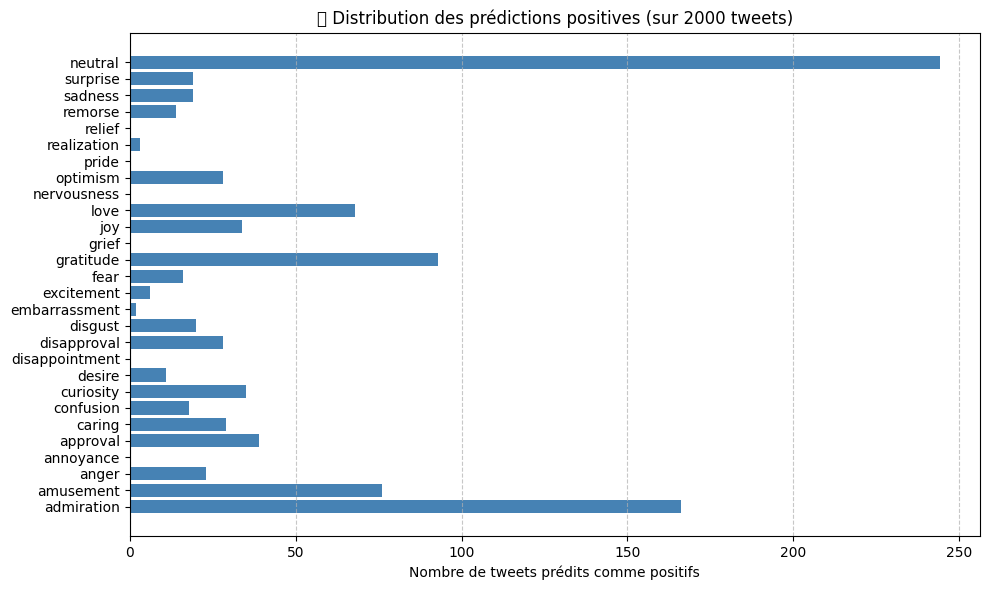

In [13]:
# Rechargement du mod√®le entra√Æn√© (chemin relatif depuis notebooks/)
model = AutoModelForSequenceClassification.from_pretrained("models/emotions/model")
tokenizer = AutoTokenizer.from_pretrained("models/emotions/tokenizer")
model.eval()

# √âchantillon de test
df_test = df.sample(n = 2000, random_state = 70).reset_index(drop = True)
texts = df_test["text"].tolist()

# Tokenisation
encodings = tokenizer(texts, truncation = True, padding = True, return_tensors = "pt")

# Pr√©diction
with torch.no_grad():
    outputs = model(**encodings)

# Conversion logits ‚Üí pr√©dictions binaires
logits = outputs.logits.detach().numpy()
preds = (logits > 0).astype(int)

# Calcul du total de pr√©dictions positives par √©motion
pred_counts = preds.sum(axis=0)

# Affichage
plt.figure(figsize = (10, 6))
plt.barh(range(len(emotion_cols)), pred_counts, color = 'steelblue')
plt.yticks(ticks = range(len(emotion_cols)), labels = emotion_cols)
plt.title("üìä Distribution des pr√©dictions positives (sur 2000 tweets)")
plt.xlabel("Nombre de tweets pr√©dits comme positifs")
plt.grid(axis = "x", linestyle = "--", alpha = 0.7)
plt.tight_layout()
plt.show()

In [14]:
print(f"‚úîÔ∏è Nombre d'√©motions dans emotion_cols : {len(emotion_cols)}")
print(f"‚úîÔ∏è Nombre de colonnes dans les pr√©dictions : {pred_counts.shape}")

‚úîÔ∏è Nombre d'√©motions dans emotion_cols : 28
‚úîÔ∏è Nombre de colonnes dans les pr√©dictions : (28,)


## 8.2 - Comparaison VRAI vs PR√âDIT (2000 tweets)

C:\Users\motar\AppData\Local\Temp\ipykernel_21052\4263936731.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


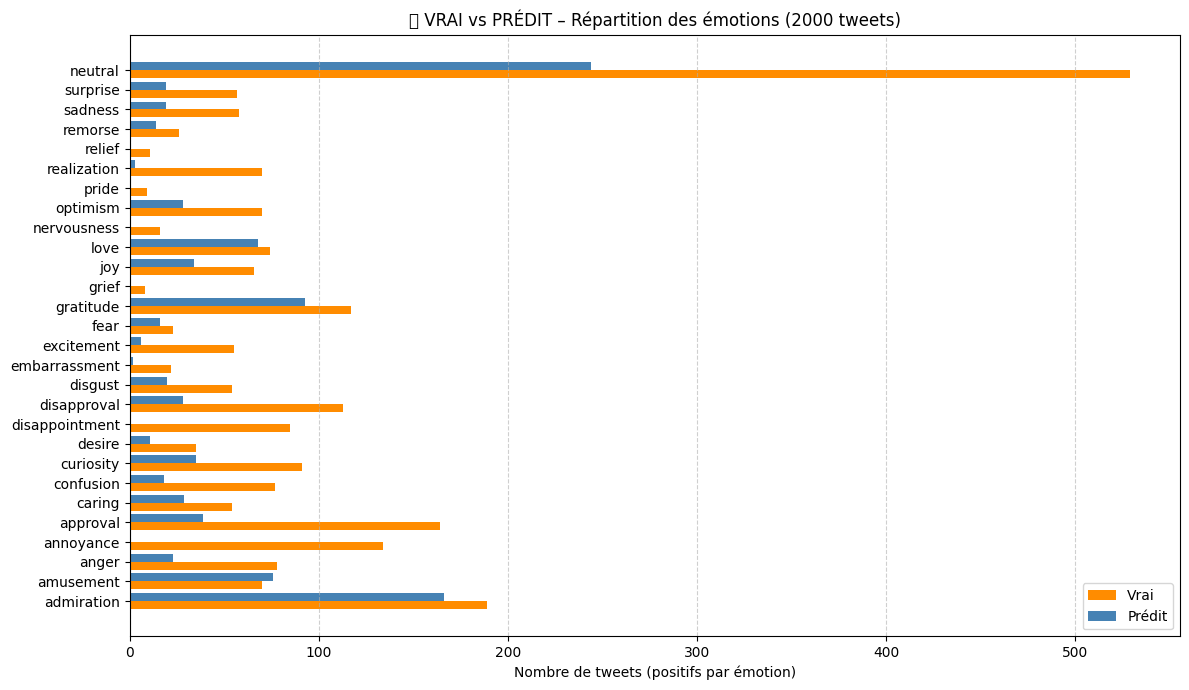

In [15]:
# R√©partition r√©elle (ground truth)
true_counts = df_test[emotion_cols].sum().values

# R√©partition des pr√©dictions (d√©j√† calcul√©e pr√©c√©demment)
pred_counts = preds.sum(axis=0)  # ‚Üê d√©j√† d√©fini

# Affichage comparatif
x = np.arange(len(emotion_cols))  # positions
width = 0.4

plt.figure(figsize=(12, 7))
plt.barh(x - width/2, true_counts, height=width, label='Vrai', color='darkorange')
plt.barh(x + width/2, pred_counts, height=width, label='Pr√©dit', color='steelblue')

plt.yticks(ticks=x, labels=emotion_cols)
plt.xlabel("Nombre de tweets (positifs par √©motion)")
plt.title("üìä VRAI vs PR√âDIT ‚Äì R√©partition des √©motions (2000 tweets)")
plt.legend(loc="lower right")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## 8.3 - Heatmap de co-occurrence des √©motions pr√©dites

C:\Users\motar\AppData\Local\Temp\ipykernel_21052\1794568889.py:11: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


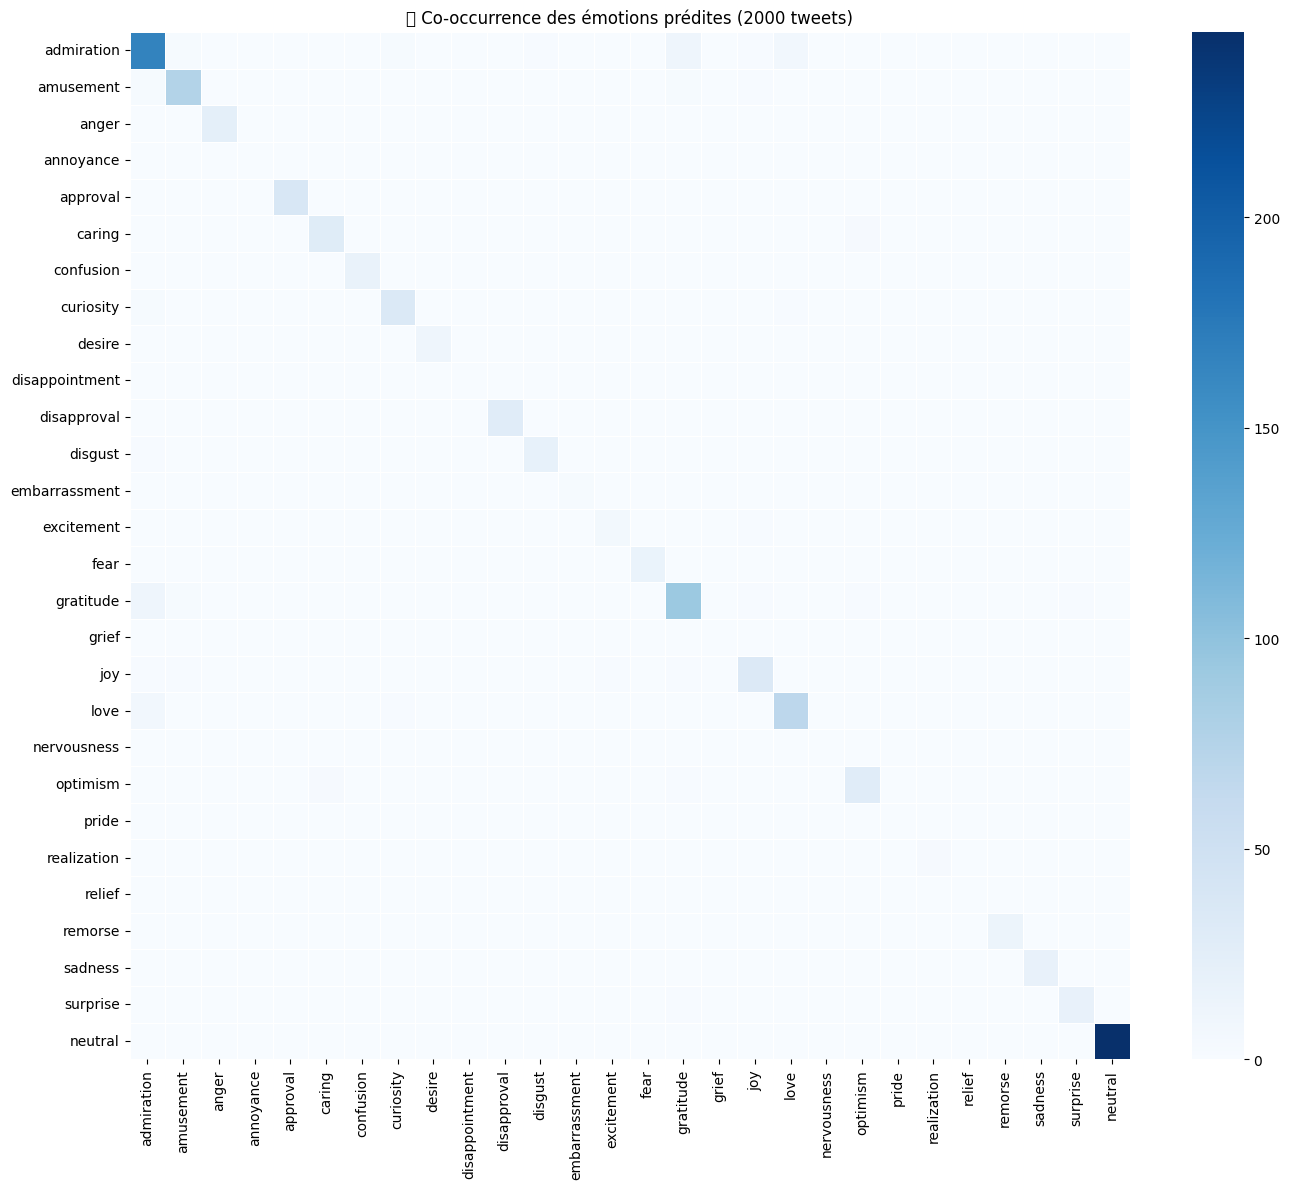

In [16]:
# Cr√©ation d‚Äôune DataFrame des pr√©dictions binaires (2000 tweets √ó 28 √©motions)
pred_df = pd.DataFrame(preds, columns  =emotion_cols)

# Matrice de co-occurrence (corr√©lation binaire entre √©motions)
co_matrix = pred_df.T.dot(pred_df)

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(co_matrix, xticklabels=emotion_cols, yticklabels=emotion_cols, cmap="Blues", linewidths=0.5)
plt.title("üî• Co-occurrence des √©motions pr√©dites (2000 tweets)")
plt.tight_layout()
plt.show()

## 8.4 - Export CSV des stats d‚Äô√©motions par label

In [17]:
stats_df = pd.DataFrame({
    "emotion": emotion_cols,
    "true_count": true_counts,
    "pred_count": pred_counts,
    "difference": pred_counts - true_counts,
    "abs_error": np.abs(pred_counts - true_counts)
})

stats_df.sort_values(by="abs_error", ascending=False, inplace=True)
export_path = os.path.join("..", "outputs", "emotion_stats_2000.csv")
os.makedirs(os.path.dirname(export_path), exist_ok=True)
stats_df.to_csv(export_path, index=False, encoding="utf-8")

print(f"üìÅ Statistiques export√©es avec succ√®s dans : {export_path}")
display(stats_df.head(10))

üìÅ Statistiques export√©es avec succ√®s dans : ..\outputs\emotion_stats_2000.csv


emotion  true_count  pred_count  difference  abs_error
27         neutral         529         244        -285        285
3        annoyance         134           0        -134        134
4         approval         164          39        -125        125
10     disapproval         113          28         -85         85
9   disappointment          85           0         -85         85
22     realization          70           3         -67         67
6        confusion          77          18         -59         59
7        curiosity          91          35         -56         56
2            anger          78          23         -55         55
13      excitement          55           6         -49         49

# 9 - V√©rification des artefacts

In [18]:
print("\nüóÇÔ∏è Mod√®les enregistr√©s :")
afficher_arborescence("models/emotions", niveau_max = 2)


üóÇÔ∏è Mod√®les enregistr√©s :
‚îú‚îÄ‚îÄ checkpoint-12476
‚îÇ   ‚îú‚îÄ‚îÄ config.json
‚îÇ   ‚îú‚îÄ‚îÄ optimizer.pt
‚îÇ   ‚îú‚îÄ‚îÄ pytorch_model.bin
‚îÇ   ‚îú‚îÄ‚îÄ rng_state.pth
‚îÇ   ‚îú‚îÄ‚îÄ scheduler.pt
‚îÇ   ‚îú‚îÄ‚îÄ special_tokens_map.json
‚îÇ   ‚îú‚îÄ‚îÄ tokenizer.json
‚îÇ   ‚îú‚îÄ‚îÄ tokenizer_config.json
‚îÇ   ‚îú‚îÄ‚îÄ trainer_state.json
‚îÇ   ‚îú‚îÄ‚îÄ training_args.bin
‚îÇ   ‚îú‚îÄ‚îÄ vocab.txt
‚îú‚îÄ‚îÄ checkpoint-15595
‚îÇ   ‚îú‚îÄ‚îÄ config.json
‚îÇ   ‚îú‚îÄ‚îÄ optimizer.pt
‚îÇ   ‚îú‚îÄ‚îÄ pytorch_model.bin
‚îÇ   ‚îú‚îÄ‚îÄ rng_state.pth
‚îÇ   ‚îú‚îÄ‚îÄ scheduler.pt
‚îÇ   ‚îú‚îÄ‚îÄ special_tokens_map.json
‚îÇ   ‚îú‚îÄ‚îÄ tokenizer.json
‚îÇ   ‚îú‚îÄ‚îÄ tokenizer_config.json
‚îÇ   ‚îú‚îÄ‚îÄ trainer_state.json
‚îÇ   ‚îú‚îÄ‚îÄ training_args.bin
‚îÇ   ‚îú‚îÄ‚îÄ vocab.txt
‚îú‚îÄ‚îÄ logs
‚îÇ   ‚îú‚îÄ‚îÄ events.out.tfevents.1746978163.PC-ARNAUD.13144.0
‚îÇ   ‚îú‚îÄ‚îÄ events.out.tfevents.1746978485.PC-ARNAUD.26512.0
‚îÇ   ‚îú‚îÄ‚îÄ events.out.tfevents.1746978666.PC-ARNAUD.476

## 9.1 - Interface de tracking MLflow (http://localhost:5000)

In [19]:
import subprocess

try:
    subprocess.Popen(["mlflow", "ui"])
    print("‚úÖ MLflow UI lanc√© sur http://localhost:5000")
except Exception as e:
    print(f"‚ùå Impossible de lancer MLflow UI : {e}")

‚úÖ MLflow UI lanc√© sur http://localhost:5000


In [20]:
import os
import mlflow

# üîß Sp√©cifie l'URI local
mlruns_path = os.path.abspath("../mlruns").replace("\\", "/")
mlflow.set_tracking_uri(f"file:///{mlruns_path}")

# üîç Recherche du mod√®le enregistr√©
client = mlflow.MlflowClient()
model_name = "emotions_classifier"

try:
    model = client.get_registered_model(model_name)
    print(f"‚úÖ Mod√®le {model.name} trouv√© avec {len(model.latest_versions)} version(s)")

    for version in model.latest_versions:
        print("üì¶ Version:", version.version)
        print("üîÅ Run ID :", version.run_id)
        print("üìÇ Source :", version.source)
        print("-" * 30)

except Exception as e:
    print(f"‚ùå Erreur : {e}")

‚úÖ Mod√®le emotions_classifier trouv√© avec 3 version(s)
üì¶ Version: 1
üîÅ Run ID : d28ed191e37a4761971a3332f9ff0a29
üìÇ Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/d28ed191e37a4761971a3332f9ff0a29/artifacts/emotions_model
------------------------------
üì¶ Version: 3
üîÅ Run ID : 4589d8f9e2514c11866d287cc1c506ce
üìÇ Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/4589d8f9e2514c11866d287cc1c506ce/artifacts/emotions_model
------------------------------
üì¶ Version: 2
üîÅ Run ID : 2a4098924208444baa1d3cffcc3abb70
üìÇ Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/2a4098924208444baa1d3cffcc3abb70/artifacts/emotions_model
------------------------------


In [21]:
# Charger les m√©triques
metrics = joblib.load(open("models/emotions/metrics.pkl", "rb"))

# Afficher le graphe
plot_normalized_metrics(metrics, model_name="ELECTRA ‚Äì GoEmotions")

ValueError: Aucune m√©trique normalis√©e (0-1) trouv√©e dans les donn√©es.

# Lien vers l'application (ngrok) :
# https://f22e-2a01-cb1d-8598-1400-4ac7-ab2e-4237-81aa.ngrok-free.app